In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
# Show Current Working Directory
%pwd

'C:\\Users\\Ryan Tamashiro\\Desktop\\Ryan\\UCI Bootcamp\\Class Repo\\02-Homework\\10-Advanced-Data-Storage-and-Retrieval\\Instructions'

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
from sqlalchemy import create_engine, inspect
from sqlalchemy import func, desc
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
inspector = inspect(engine)

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Set 'Measurements' Table Ref
Measurement = Base.classes.measurement

# Preview 'measurements' Field Names
for i, fld in enumerate(inspector.get_columns('measurement')):
    print(i, fld['name'])

0 id
1 station
2 date
3 prcp
4 tobs


In [10]:
# Set 'Station' Table Ref
Station = Base.classes.station

# Preview 'station' Field Names
for i, fld in enumerate(inspector.get_columns('station')):
    print(i, fld['name'])

0 id
1 station
2 name
3 latitude
4 longitude
5 elevation


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
station_query = session.query(Station).all()
station_query[:10]

In [13]:
measurements_query = session.query(Measurement)
measurements_query[:10]

## Precipitation Analysis

### Design a query to retrieve the last 12 months of precipitation data and plot the results
1. Calculate the date 1 year ago from the last data point in the database
2. Perform a query to retrieve the data and precipitation scores
3. Save the query results as a Pandas DataFrame and set the index to the date column
4. Sort the dataframe by date
5. Use Pandas Plotting with Matplotlib to plot the data

In [14]:
# Design a Query to Retrieve the Last 12 Months of Precipitation Data and Plot The Results
base_query = session.query(Measurement)

In [15]:
# Calculate the Date 1 Year AGo From the Last Data Point in the Database
# Return last Recorded Date
last_record_date = base_query.order_by(desc(Measurement.date)).first().date

# Convert to DateTime Format
end_date = dt.datetime.strptime(last_record_date, '%Y-%m-%d')

# Calculate Start Date (end_date - 1 year)
start_date = end_date + dt.timedelta(days=-366)

In [16]:
# Preview Query Start & End Dates
print(f'Start Date: {start_date}\n'
      f'End Date: {end_date}')

Start Date: 2016-08-22 00:00:00
End Date: 2017-08-23 00:00:00


In [17]:
# Perform a Query to Retrieve The Data and Precipitation Scores
weather_data = session.query(Measurement.date, Measurement.prcp) \
                            .filter(Measurement.date.between(start_date, end_date)).all()

weather_data[:10]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0)]

In [18]:
# Save the Query Results as a Pandas DataFrame and Set the Index to the Date Column
weather_df = pd.DataFrame(weather_data)
weather_df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [19]:
# Sort the DataFrame by Date
sorted_weather_df = weather_df.sort_values('date')
sorted_weather_df.head(5)

,date,prcp
0,2016-08-23,0.00
1009,2016-08-23,NaN
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15


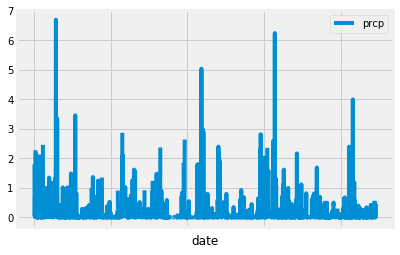

In [20]:
# Plot Precipitation Data (Past 12 Months)
sorted_weather_df.set_index('date').plot()

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_weather_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

### 1. Design a Query to Calculate the Total Number of Stations

### 2. Design a Query to Find the Most Active Stations:
        a. List Stations & Observations in Descending Order.
        b. Which Station Has the Highest Number of Observations?
        
### 3. Design a Query to Retrieve Last 12 Months of Temperature Observation Datat(tobs)
        a. Filter by the Station With The Highest Number of Observations
        b. Plot the Results as a Histogram w/ bins=12

In [22]:
# Preview 'Station' Table
for i, fld in enumerate(inspector.get_columns('measurement')):
    print(i, fld['name'])

0 id
1 station
2 date
3 prcp
4 tobs


In [23]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).distinct().count()
station_count

9

In [24]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station).label('activity')) \
                                .group_by(Measurement.station) \
                                .order_by(desc('activity'))

for result in station_activity.all():
    print(f'Station Name: {result.station} >> Record Count: {result.activity}')

Station Name: USC00519281 >> Record Count: 2772
Station Name: USC00519397 >> Record Count: 2724
Station Name: USC00513117 >> Record Count: 2709
Station Name: USC00519523 >> Record Count: 2669
Station Name: USC00516128 >> Record Count: 2612
Station Name: USC00514830 >> Record Count: 2202
Station Name: USC00511918 >> Record Count: 1979
Station Name: USC00517948 >> Record Count: 1372
Station Name: USC00518838 >> Record Count: 511


In [25]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
lowest_temp = session.query(Measurement) \
                           .filter(Measurement.station == station_activity.first()[0]) \
                           .order_by(Measurement.tobs).first()
print(lowest_temp.tobs)

54.0


In [26]:
# Using the Station ID From the Previous Query, Calculate the Highest Temperature Recorded
highest_temp = session.query(Measurement) \
                           .filter(Measurement.station == station_activity.first()[0]) \
                           .order_by(desc(Measurement.tobs)).first()
print(highest_temp.tobs)

85.0


In [27]:
# Using the Station ID From the Previous Query, Calculate the Average Temperature at Most Active Station
average_temp = session.query(Measurement.station, func.avg(Measurement.tobs).label('avg')) \
                            .filter(Measurement.station == station_activity.first()[0]).first()
print(average_temp.avg)

71.66378066378067


In [28]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = session.query(Measurement.station, Measurement.date, Measurement.tobs) \
                                   .filter(Measurement.station == station_activity.first()[0]) \
                                   .filter(Measurement.date.between(start_date, end_date)).all()
most_active_station[:10]

[('USC00519281', '2016-08-23', 77.0),
 ('USC00519281', '2016-08-24', 77.0),
 ('USC00519281', '2016-08-25', 80.0),
 ('USC00519281', '2016-08-26', 80.0),
 ('USC00519281', '2016-08-27', 75.0),
 ('USC00519281', '2016-08-28', 73.0),
 ('USC00519281', '2016-08-29', 78.0),
 ('USC00519281', '2016-08-30', 77.0),
 ('USC00519281', '2016-08-31', 78.0),
 ('USC00519281', '2016-09-01', 80.0)]

In [29]:
# Convert Query Results to DataFrame
plot_activity_df = pd.DataFrame(most_active_station)
plot_activity_df.head(10)

,station,date,tobs
0,USC00519281,2016-08-23,77.0
1,USC00519281,2016-08-24,77.0
2,USC00519281,2016-08-25,80.0
3,USC00519281,2016-08-26,80.0
4,USC00519281,2016-08-27,75.0
5,USC00519281,2016-08-28,73.0
6,USC00519281,2016-08-29,78.0
7,USC00519281,2016-08-30,77.0
8,USC00519281,2016-08-31,78.0
9,USC00519281,2016-09-01,80.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002482C27E8D0>]],
      dtype=object)

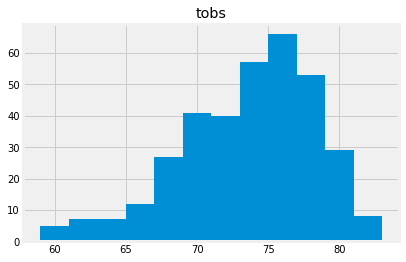

In [30]:
# Plot as Histogram Distribution of Temperatures at Most Active Station
plot_activity_df.hist(bins=12)

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """      
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [32]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_TMIN, prev_TAVG, prev_TMAX = calc_temps('2011-02-28', '2011-03-05')[0]

print(f'Previous Min. Temp: {round(prev_TMIN, 1)}\n'
      f'Previous Avg. Temp: {round(prev_TAVG, 1)}\n'
      f'Previous Max. Temp: {round(prev_TMAX, 1)}')

Previous Min. Temp: 61.0
Previous Avg. Temp: 69.8
Previous Max. Temp: 75.0


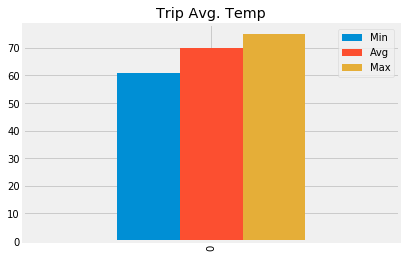

In [33]:
# Plot the results from your previous query as a bar chart. 
trip_temps = {
                'Min': [prev_TMIN],
                'Avg': [prev_TAVG],
                'Max': [prev_TMAX]
             }

trip_temps_df = pd.DataFrame(trip_temps)
trip_temps_df.plot(kind='bar')
plt.title('Trip Avg. Temp')
plt.show()

In [34]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [35]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [36]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [37]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [38]:
# Plot the daily normals as an area plot with `stacked=False`
